In [1]:
import torch
import drlqap.nn
import drlqap.qap
import drlqap.simplesolver
import matplotlib.pyplot as plt

In [2]:
from bokeh.palettes import Dark2_8
from bokeh.models import Range1d
from bokeh.plotting import figure, show, gridplot
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
n = 8
w = 32

In [4]:
with open("../qapdata/testgraph.dat", "r") as f:
    qap = drlqap.qap.GraphAssignmentProblem.from_qaplib_string(f.read())

optimal_value, optimal_assignment = drlqap.simplesolver.solve_qap_backtracking(qap)
optimal_matrix = torch.eye(qap.size)[optimal_assignment]    

input_matrix1 = torch.rand((n, w))
input_matrix2 = torch.rand((n, w))
input_tuple = (input_matrix1, input_matrix2)

tensor(0.1250)


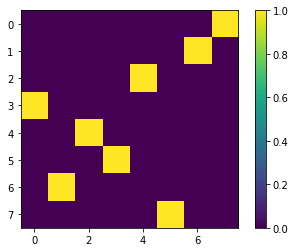

In [5]:
#output_matrix = torch.rand((n, w))
output_matrix = optimal_matrix
print(output_matrix.mean())
plt.imshow(output_matrix)
plt.colorbar()

In [6]:
results = {}

In [13]:
class LinkNet(torch.nn.Module):
    def __init__(self, encoder_depth, depth, layer_norm, encoder_ln=False):
        super().__init__()
        if encoder_depth is not None:
            self.a_net = drlqap.nn.FullyConnected(w, w, w, encoder_depth, activation=torch.nn.LeakyReLU, layer_norm=encoder_ln)
            self.b_net = drlqap.nn.FullyConnected(w, w, w, encoder_depth, activation=torch.nn.LeakyReLU, layer_norm=encoder_ln)
        else:
            self.a_net = lambda x: x
            self.b_net = lambda x: x
        
        if layer_norm:
            self.ln = torch.nn.LayerNorm((w*2))
        else:
            self.ln = lambda x: x
        
        self.main_net = drlqap.nn.FullyConnectedLinearOut(w*2, w, 1, depth, activation=torch.nn.LeakyReLU)
        
    def forward(self, a, b):
        a = self.a_net(a)
        b = self.b_net(b)
        pairs = drlqap.nn.cartesian_product_matrix(a, b)
        pairs = self.ln(pairs)
        return self.main_net(pairs)

nets = {
    "base": lambda: LinkNet(None, 3, False),
    "encoder_D2": lambda: LinkNet(2, 3, False),
    "encoder_D4": lambda: LinkNet(4, 3, False),
    "LN": lambda: LinkNet(None, 3, True),
    "encoder+LN_D2": lambda: LinkNet(2, 3, True),
    "encoder+LN_D4": lambda: LinkNet(4, 3, True),
}

In [14]:
def train(net, epochs, *inputs, lr=0.01):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)   
    losses = []
    target = output_matrix
    for i in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        net_output = net(*inputs)
        loss = torch.nn.functional.mse_loss(net_output.flatten(), target.flatten())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [15]:
repetitions = 4
for name, net_constructor in nets.items():
    current_results = results[name] if name in results else []
    for i in range(len(current_results), repetitions):
        net = net_constructor()
        losses = train(net, 1000, *input_tuple, lr=1e-3)
        print(f"{name} final loss: {losses[-1]}")
        current_results.append((net, losses))
    results[name] = current_results

print("done")

encoder_D4 final loss: 0.1093749925494194
encoder_D4 final loss: 0.015625618398189545
encoder_D4 final loss: 0.10937502980232239
encoder_D4 final loss: 0.1093750074505806
encoder+LN_D4 final loss: 7.504911536670988e-07
encoder+LN_D4 final loss: 5.208159450376115e-07
encoder+LN_D4 final loss: 1.271299083782651e-07
encoder+LN_D4 final loss: 3.2982040920614963e-07
done


In [16]:
fig = figure()

def moving_average(x, n=3) :
    return np.mean(sliding_window_view(x, window_shape=n), axis=-1)

for i, (name, net_runs) in enumerate(results.items()):
    x = range(len(net_runs[0][1]))
    for net, loss in net_runs:
        fig.line(x=x, y=loss, legend_label=name, color=Dark2_8[i])
    #average_loss = np.mean([run[1] for run in net_runs], axis=0)
    #fig.line(x=x, y=average_loss, legend_label=name, color=Dark2_5[i])

fig.y_range = Range1d(0,0.2)
fig.legend.click_policy = "hide"
show(fig)

In [11]:
grid = []

with torch.no_grad():
    for name, net_results in results.items():
        gridrow = []
        for net, losses in net_results:
            net_output = net(*input_tuple).squeeze()
            data = dict(value=[net_output.numpy()])
            fig = figure(
                title=name,
                tools="hover",
                tooltips=[("Value", "@value")]
            )
            fig.image(
                source=data, 
                image="value",
                x=0, y=0, 
                dw=n, dh=n, 
                palette="Viridis256"
            )
            gridrow.append(fig)
        grid.append(gridrow)
    show(gridplot(grid, sizing_mode="scale_width"))

Target


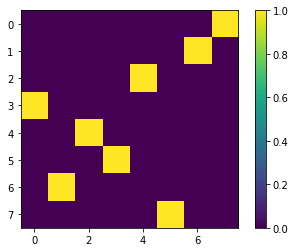

Mean


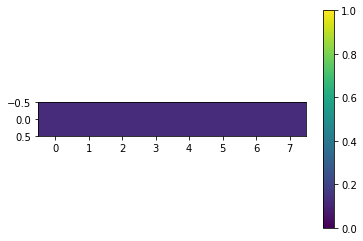

In [12]:
output_mean = torch.mean(output_matrix, dim=0, keepdims=True)
print("Target")
plt.imshow(output_matrix, vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Mean")
plt.imshow(output_mean, vmin=0, vmax=1)
plt.colorbar()
plt.show()